# LOAD PACKAGES

In [37]:
# Load packages
import numpy as np  
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
print "Read in packages from numpy, pandas, sklearn, seaborn & matplotlib"

Read in packages from numpy, pandas, sklearn, seaborn & matplotlib


# PICKLING

In [38]:
from six.moves import cPickle as pickle
pickle_file = 'train_set.pickle'

## Read from Pickle

In [39]:
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    ptrain_set = save['train_set']
    del save  # hint to help gc free up memory
    print('Loaded ptrain_set', ptrain_set.shape)
    
f.close()

('Loaded ptrain_set', (190080, 18))


# TRAIN / TEST SPLIT

In [40]:
# Split train / test data - for coarse training
# Dropping data from Jan 1 because it is a holiday
train_days     = range(2,16)
train_times    = range(39,140,4)

test_days      = range(16, 22)
test_times     = range(39,140,4)

X_train     = ptrain_set[(ptrain_set['num_day'].isin(train_days))    & (ptrain_set['time_slot'].isin(train_times))]
X_test      = ptrain_set[(ptrain_set['num_day'].isin(test_days))     & (ptrain_set['time_slot'].isin(test_times))]

print "Shape of X_train, X_test:", X_train.shape, X_test.shape, "\n\n"

Shape of X_train, X_test: (24024, 18) (10296, 18) 




In [41]:
for pc in range(0,6):
    print (X_train[(X_train['poi_cluster'].isin([pc]))].shape)

(13832, 18)
(1092, 18)
(364, 18)
(2912, 18)
(728, 18)
(5096, 18)


## SCALING

In [42]:
# Scaling for input features
# Generate scaled features for train & test sets

import warnings
warnings.filterwarnings('ignore')

gap_predictors = ['time_slot', 'week_day', 'demand_t-1', 'demand_t-2', 'demand_t-3',
                  'supply_t-1', 'supply_t-2', 'supply_t-3', 'poi_cluster', 'congestion'] 

gX_train = []
gy_train = []
gX_test  = []
gy_test  = []

# Normalize features - both training & test
g_scaler = StandardScaler().fit(ptrain_set[gap_predictors])
gap_scaler = StandardScaler().fit(ptrain_set['gap'])

# Input Samples and Target Values for Gap(g)
gX_train  = g_scaler.transform(X_train[gap_predictors])
gy_train  = gap_scaler.transform(X_train['gap'])

gX_test = g_scaler.transform(X_test[gap_predictors])
gy_test = gap_scaler.transform(X_test['gap'])

## SCORES

In [43]:
# Calculate the MAPE Score
def mape_score(exp, pred, q):
    
    # q = (num_days * num_slots) -1
    mape = 0.0
    n = 66.0
    
    for gap, gapX in zip(exp, pred):
        if gap > 0:
            mape += 1.0 * abs((gap-gapX)/gap)
    return (mape/(n*q))

# Print Scores & Present as a table - Mean Squared, R2, MAPE
def print_score(y_train, y_pred_train, y_test, y_pred_test):
    
    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    mpscore_train    = mape_score(y_train,    y_pred_train, 363)
    mpscore_test     = mape_score(y_test,     y_pred_test, 155)


    sets_list = ["TRAIN", "TEST"]

    m2_scores = [m2score_train, m2score_test]
    r2_scores = [r2score_train, r2score_test]
    mp_scores = [mpscore_train, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'

    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.2f}\t\t{2:.2f}\t\t{3:.2f}' .format(s, m, r, mp)

        
# Evaluate Scores & Present as a table - Mean Squared, R2, MAPE
def eval_score(y_train, y_pred_train, y_test, y_pred_test):
    
    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    mpscore_train    = mape_score(y_train,    y_pred_train, 363)
    mpscore_test     = mape_score(y_test,     y_pred_test, 155)


    sets_list = ["TRAIN", "TEST"]

    m2_scores = [m2score_train, m2score_test]
    r2_scores = [r2score_train, r2score_test]
    mp_scores = [mpscore_train, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'


    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.2f}\t\t{2:.2f}\t\t{3:.2f}' .format(s, m, r, mp)

In [44]:
from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mape_score, greater_is_better=False, q=363)

In [45]:
# Use fit function to generate predictions for train and test sets
# Evaluate scores and print results
# Used for demand, supply predictions
def predict_score(train_set, test_set, predictors, exp_col, fitfunc, *fitargs):

    # Generate dataframe for train & test
    Xtrain_df    = train_set[predictors]
    Xtest_df     = test_set[predictors]
    
    # Generate predictions for train & test
    y_pred_train    = fitfunc(Xtrain_df,    *fitargs)
    y_pred_test     = fitfunc(Xtest_df,     *fitargs)

    # Extract expected train & test values
    y_train    = train_set[exp_col]
    y_test     = test_set[exp_col]

    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    mpscore_train    = mape_score(y_train,    y_pred_train, 363)
    mpscore_test     = mape_score(y_test,     y_pred_test, 155)


    sets_list = ["TRAIN", "TEST"]

    m2_scores = [m2score_train, m2score_test]
    r2_scores = [r2score_train, r2score_test]
    mp_scores = [mpscore_train, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'


    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.2f}\t\t{2:.2f}\t\t{3:.2f}' .format(s, m, r, mp)
    
    return(y_pred_train, y_pred_test)

## LEARNING CURVES

In [46]:
# Generates training vs cross-validation curves

print(__doc__)

from sklearn import cross_validation
from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2 Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Automatically created module for IPython interactive environment


## DEMAND, SUPPLY PREDICTIONS & GAP FORECASTING

In [47]:
def analyze_error(gapy_pred_train, gapy_pred_test):
    
    Xerr_train = pd.DataFrame()
    Xerr_test  = pd.DataFrame()
    
    Xerr_train = X_train.copy()
    Xerr_test  = X_test.copy()
    
    # Drop columns that will not be used for analysis
    Xerr_train.drop(['weather', 'temperature', 'pollution', 
                     'demand_t-1', 'demand_t-2', 'demand_t-3', 
                     'supply_t-1', 'supply_t-2', 'supply_t-3'],
                    axis=1, inplace=True)
    
    Xerr_test.drop(['weather', 'temperature', 'pollution', 
                    'demand_t-1', 'demand_t-2', 'demand_t-3', 
                    'supply_t-1', 'supply_t-2', 'supply_t-3'], 
                   axis=1, inplace=True)
    
    
    # Create new columns that store errors
    Xerr_train['gap_error'] = X_train['gap']    - gapy_pred_train
    Xerr_test['gap_error'] = X_test['gap']    - gapy_pred_test
    
    print '\nTrain error correlation matrix:\n', Xerr_train.corr()
    print '\nTest error correlation matrix:\n', Xerr_test.corr()    
  
    print '\nTest Error Joint Plot\n'
    for y in ['demand', 'gap', 'supply', 'district_id', 'num_day', 'time_slot', 'week_day', 'poi_cluster', 'congestion']:
        g = sns.jointplot('gap_error', y, data=Xerr_train, kind="reg",color="r", size=3)
    plt.show()
    
    print '\nTrain Error Joint Plot\n'
    for y in ['demand', 'gap', 'supply', 'district_id', 'num_day', 'time_slot', 'week_day', 'poi_cluster', 'congestion']:
        g = sns.jointplot('gap_error', y, data=Xerr_test, kind="reg",color="r", size=3)
    plt.show()

In [48]:
# Generate Demand Supply Gap Metrics based on provided fit functions
# Assumes expected values for gap is in namesake column
def gap_estimate(**kwargs):
    
    gX_train     = kwargs["gX_train"]
    gX_test      = kwargs["gX_test"]
    g_fitfunc    = kwargs["g_fitfunc"]
    
    print "\n\nGAP FORECASTING"
    print     "==============="

    # Generate predictions for train & test sets
    gy_pred_train    = gap_scaler.inverse_transform(g_fitfunc.predict(gX_train))
    gy_pred_test     = gap_scaler.inverse_transform(g_fitfunc.predict(gX_test))

    # Extract expected train & test values
    gy_train    = X_train['gap']
    gy_test     = X_test['gap']

    # Evaluate scores and print results
    print_score(gy_train, gy_pred_train, gy_test, gy_pred_test)
   
    analyze_error(gy_pred_train, gy_pred_test)
    
    return


# Generate Demand Supply Gap Metrics based on provided fit functions
# Assumes expected values for demand, supply, gap are in namesake columns
def gap_forecast(**kwargs):
    
    X_train      = kwargs["train_set"]
    X_test       = kwargs["test_set"]
    r_predictors = kwargs["demand_predictors"]
    a_predictors = kwargs["supply_predictors"]
    r_fitfunc    = kwargs["rfit_func"]
    r_fitargs    = kwargs["rfit_args"]
    a_fitfunc    = kwargs["afit_func"]
    a_fitargs    = kwargs["afit_args"]
    
    print "\n\nDEMAND FORECASTING"
    print     "=================="

    ry_pred_train, ry_pred_test = predict_score(X_train, X_test, r_predictors, 'demand', r_fitfunc, *r_fitargs)

    print "\n\nSUPPLY FORECASTING"
    print     "=================="

    ay_pred_train, ay_pred_test = predict_score(X_train, X_test, a_predictors, 'supply', a_fitfunc, *a_fitargs)

    print "\n\nGAP FORECASTING"
    print     "==============="

    gapy_pred_train    = [r - a for r, a in zip(ry_pred_train,    ay_pred_train)]
    gapy_pred_test     = [r - a for r, a in zip(ry_pred_test,     ay_pred_test)]

    gapy_train    = X_train['gap']
    gapy_test     = X_test['gap']

    eval_score(gapy_train, gapy_pred_train, gapy_test, gapy_pred_test)
    
    return

In [49]:
# Generate learning curves by varying training sizes
# Use Training vs Cross-validation curves
def generate_learningcurves(**kwargs):    
   
    gX_train      = kwargs["gX_train"]
    gy_train      = kwargs["gy_train"]
        
    alg           = kwargs["alg"]
    alg_name      = kwargs["alg_name"]
          
    # Plot learning curve - Demand
    X, y = gX_train, gy_train

    title = 'Learning Curves for Gap (' + alg_name + ')'

    # Cross validation with 25 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=25, test_size=0.2, random_state=0)

    estimator = alg
    plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(.01, 1.0, 20))
    plt.show()

In [50]:
# Generate learning curves by varying training sizes
# Use Training vs Cross-validation curves
def generate_traintestscores(**kwargs):    
   
    gX_train      = kwargs["gX_train"]
    gy_train      = kwargs["gy_train"]
    gX_test       = kwargs["gX_test"]
    gy_test       = kwargs["gy_test"]
        
    alg           = kwargs["alg"]
    alg_name      = kwargs["alg_name"]
    
    # Create training set of increasing sizes
    train_size_set = [4000, 8000, 12000, 16000, 20000, 24024]

    Xg_train_set = []
    yg_train_set = []   
    Xg_test = gX_test
    yg_test = gy_test


    for size in train_size_set: 
        Xg_train_set.append(gX_train[:size])
        yg_train_set.append(gy_train[:size])
    
    # Train Gap Forecaster
    print ('\nTraining Gap Forecaster - {}\n' .format(alg_name))

    for train_size, Xg_train, yg_train in zip(train_size_set, Xg_train_set, yg_train_set):
        clf = alg.fit(Xg_train, yg_train)
    
        # Scores
        train_score = clf.score(Xg_train, yg_train)
        test_score  = clf.score(Xg_test, yg_test)
        print ('Train Size: {0:.3f} Train Score: {1:.3f} Test Score: {2:.3f}' .format(train_size, train_score, test_score))

In [51]:
def select_hyperparams(**kwargs):
    
    gX_train      = kwargs['gX_train']
    gy_train      = kwargs['gy_train']
    gX_test       = kwargs["gX_test"]
    gy_test       = kwargs["gy_test"]

    
    alg           = kwargs['alg']
    alg_name      = kwargs['alg_name']
    param_grid    = kwargs['param_grid']
    scoring_func  = kwargs['scoring_func']
    
    # GAP
    # Use nested cross validation - 5x2 cross validation

    g_gs = GridSearchCV(estimator=alg,
                  param_grid=param_grid,
                  scoring=scoring_func,
                  cv=2,
                  n_jobs=-1)

    scores = cross_val_score(estimator=g_gs,
                         X=gX_train,
                         y=gy_train,
                         scoring=scoring_func,
                         cv=5)

    g_gs = g_gs.fit(X=gX_train, y=gy_train)

    print 'Best Estimator (Demand):\n', g_gs.best_estimator_
    print('CV accuracy (Demand): %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
   
    # Generate Learning Curves - Demand & Supply
    generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                            alg=g_gs.best_estimator_, alg_name=alg_name)
    
    generate_traintestscores(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                             alg=g_gs.best_estimator_, alg_name=alg_name)
    
    # Print Scores   
    gap_estimate(gX_train=gX_train, gX_test=gX_test, g_fitfunc=g_gs)

# DECISION TREES

## Default Parameters

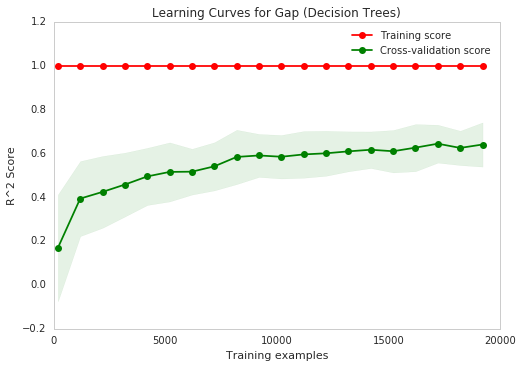


Training Gap Forecaster - Decision Trees

Train Size: 4000.000 Train Score: 1.000 Test Score: 0.596
Train Size: 8000.000 Train Score: 1.000 Test Score: 0.490
Train Size: 12000.000 Train Score: 1.000 Test Score: 0.422
Train Size: 16000.000 Train Score: 1.000 Test Score: 0.409
Train Size: 20000.000 Train Score: 1.000 Test Score: 0.752
Train Size: 24024.000 Train Score: 1.000 Test Score: 0.733


In [15]:
from sklearn.tree import DecisionTreeRegressor

# Decision Trees only supports MSE score for deciding splits
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=DecisionTreeRegressor(), alg_name="Decision Trees")

generate_traintestscores(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                         alg=DecisionTreeRegressor(), alg_name="Decision Trees")

## Hyper Parameter Selection

Best Estimator (Demand):
DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=0.75,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')
CV accuracy (Demand): -0.072 +/- 0.045


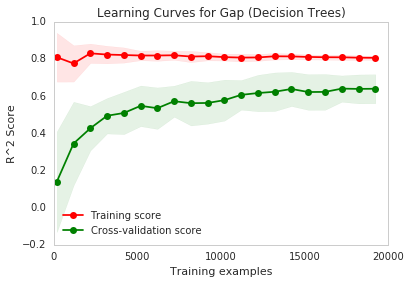


Training Gap Forecaster - Decision Trees

Train Size: 4000.000 Train Score: 0.797 Test Score: 0.498
Train Size: 8000.000 Train Score: 0.830 Test Score: 0.486
Train Size: 12000.000 Train Score: 0.773 Test Score: 0.411
Train Size: 16000.000 Train Score: 0.763 Test Score: 0.418
Train Size: 20000.000 Train Score: 0.795 Test Score: 0.731
Train Size: 24024.000 Train Score: 0.797 Test Score: 0.731


GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	251.90		0.80		0.62
TEST      	869.66		0.73		0.62

Train error correlation matrix:
             district_id       num_day  time_slot      week_day    demand  \
district_id     1.000000  0.000000e+00   0.000000  0.000000e+00 -0.152934   
num_day         0.000000  1.000000e+00   0.000000 -1.240347e-01  0.036766   
time_slot       0.000000  0.000000e+00   1.000000  0.000000e+00  0.021066   
week_day        0.000000 -1.240347e-01   0.000000  1.000000e+00 -0.022982   
demand         -0.152934  3.676635e-02   0.021066 -2.298163e-02  1.000000   
supply       

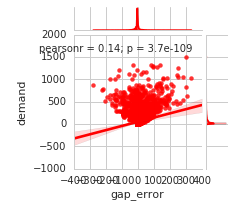

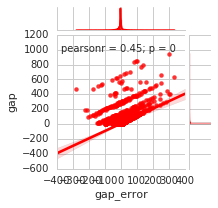

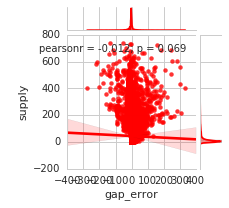

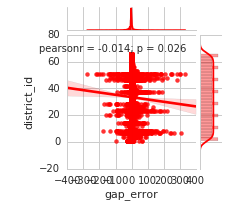

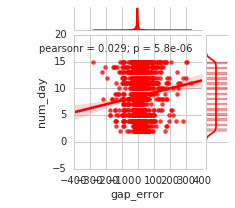

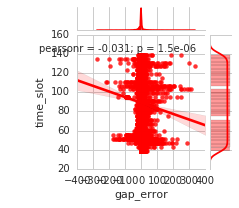

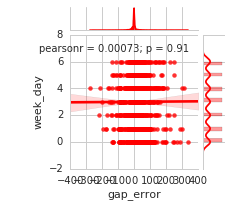

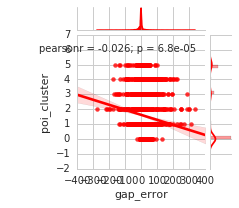

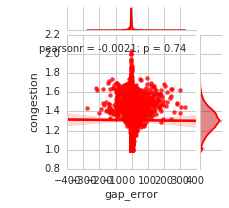


Train Error Joint Plot



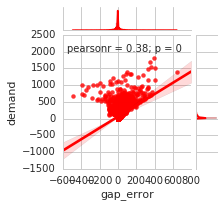

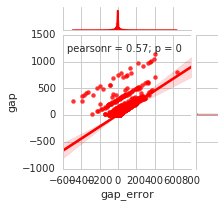

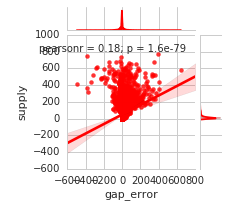

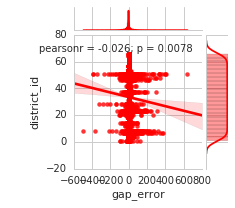

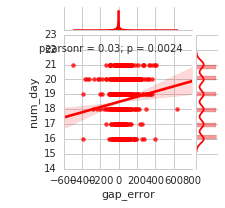

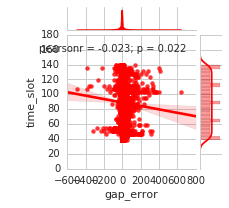

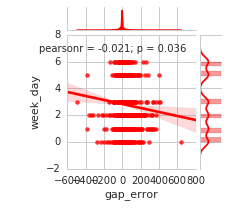

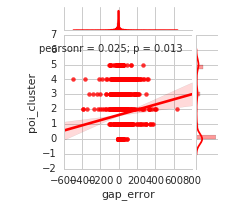

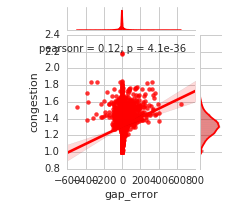

In [52]:
# Use GridSearchCV - Demand
# Specify parameters
param_grid = {'max_features'      : [0.25, 0.5, 0.75, 1.0],
              'max_depth'         : [5, 10, 15, 20, 25],
              'min_samples_split' : [2, 3, 4, 5, 10],
              'random_state'      : [0]}
             
alg = DecisionTreeRegressor()

# Only mse is supported for the DecisionTreeRegressor
# Use MAPE as scoring function for GridSearchCV, cross_val_score
select_hyperparams(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                   alg=alg, alg_name='Decision Trees', param_grid=param_grid, scoring_func=mape_scorer)

# K NEAREST NEIGHBORS

## Default Parameters

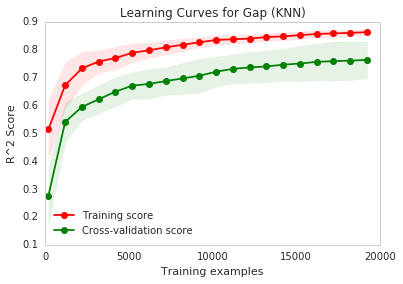


Training Gap Forecaster - KNN

Train Size: 4000.000 Train Score: 0.868 Test Score: 0.580
Train Size: 8000.000 Train Score: 0.849 Test Score: 0.590
Train Size: 12000.000 Train Score: 0.858 Test Score: 0.618
Train Size: 16000.000 Train Score: 0.860 Test Score: 0.629
Train Size: 20000.000 Train Score: 0.869 Test Score: 0.799
Train Size: 24024.000 Train Score: 0.870 Test Score: 0.799


In [54]:
from sklearn.neighbors import KNeighborsRegressor

# KNN defaults to R^2 score
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=KNeighborsRegressor(), alg_name="KNN")

generate_traintestscores(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                         alg=KNeighborsRegressor(), alg_name="KNN")

## Hyper Parameter Selection

Best Estimator (Demand):
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform')
CV accuracy (Demand): -0.059 +/- 0.033


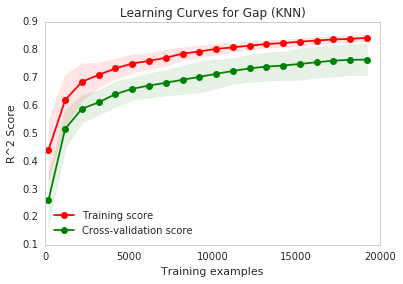


Training Gap Forecaster - KNN

Train Size: 4000.000 Train Score: 0.841 Test Score: 0.618
Train Size: 8000.000 Train Score: 0.826 Test Score: 0.624
Train Size: 12000.000 Train Score: 0.836 Test Score: 0.638
Train Size: 16000.000 Train Score: 0.840 Test Score: 0.647
Train Size: 20000.000 Train Score: 0.844 Test Score: 0.801
Train Size: 24024.000 Train Score: 0.845 Test Score: 0.801


GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	192.57		0.84		0.41
TEST      	645.32		0.80		0.48

Train error correlation matrix:
             district_id       num_day  time_slot      week_day    demand  \
district_id     1.000000  0.000000e+00   0.000000  0.000000e+00 -0.152934   
num_day         0.000000  1.000000e+00   0.000000 -1.240347e-01  0.036766   
time_slot       0.000000  0.000000e+00   1.000000  0.000000e+00  0.021066   
week_day        0.000000 -1.240347e-01   0.000000  1.000000e+00 -0.022982   
demand         -0.152934  3.676635e-02   0.021066 -2.298163e-02  1.000000   
supply         -0.172786

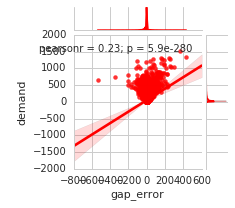

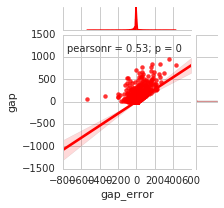

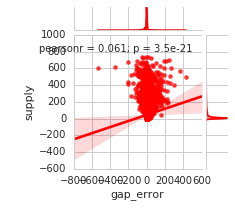

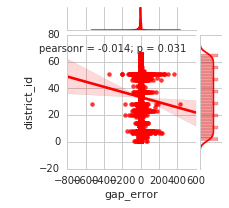

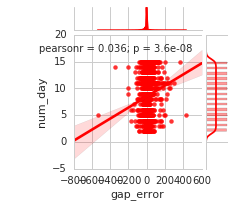

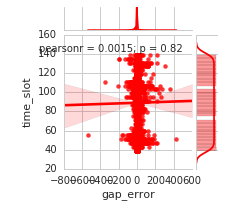

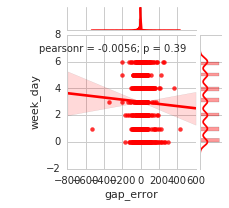

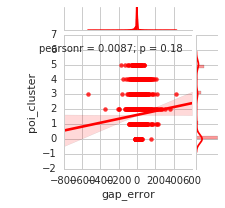

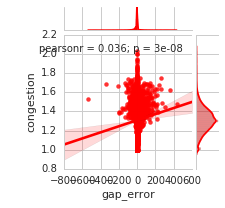


Train Error Joint Plot



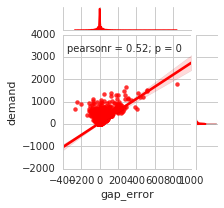

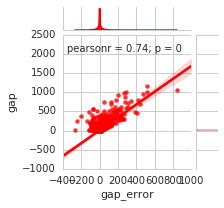

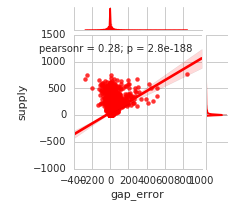

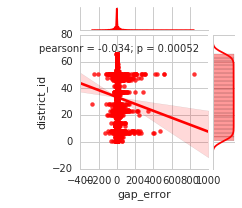

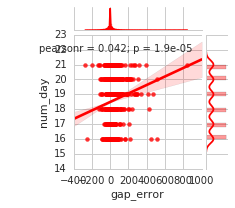

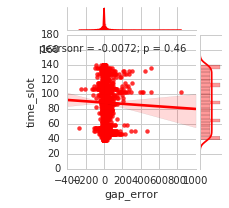

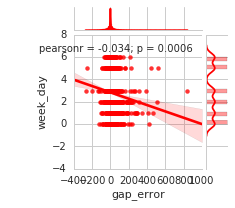

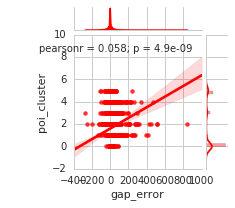

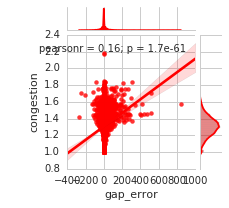

In [56]:
# Use GridSearchCV
# Specify parameters
param_grid = {'n_neighbors'       : [3, 5, 7, 10],
              'weights'           : ['uniform', 'distance'],
              'metric'            : ['euclidean', 'minkowski']}

alg = KNeighborsRegressor()

# Use MAPE as scoring function
select_hyperparams(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                   alg=alg, alg_name='KNN', param_grid=param_grid, scoring_func=mape_scorer)

# SUPPORT VECTOR MACHINES

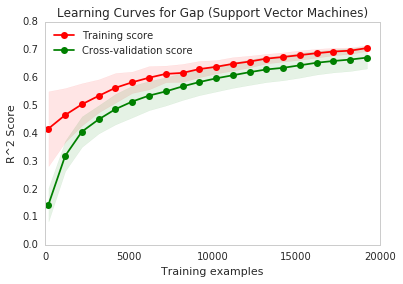


Training Gap Forecaster - Support Vector Machines

Train Size: 4000.000 Train Score: 0.757 Test Score: 0.426
Train Size: 8000.000 Train Score: 0.741 Test Score: 0.404
Train Size: 12000.000 Train Score: 0.741 Test Score: 0.453
Train Size: 16000.000 Train Score: 0.761 Test Score: 0.456
Train Size: 20000.000 Train Score: 0.727 Test Score: 0.606
Train Size: 24024.000 Train Score: 0.728 Test Score: 0.605


In [59]:
from sklearn.svm import SVR

# SVM defaults to R^2 score
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=SVR(), alg_name="Support Vector Machines")

generate_traintestscores(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                         alg=SVR(), alg_name="Support Vector Machines")



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	337.14		0.73		0.50
TEST      	1278.91		0.61		0.52

Train error correlation matrix:
             district_id       num_day  time_slot      week_day    demand  \
district_id     1.000000  0.000000e+00   0.000000  0.000000e+00 -0.152934   
num_day         0.000000  1.000000e+00   0.000000 -1.240347e-01  0.036766   
time_slot       0.000000  0.000000e+00   1.000000  0.000000e+00  0.021066   
week_day        0.000000 -1.240347e-01   0.000000  1.000000e+00 -0.022982   
demand         -0.152934  3.676635e-02   0.021066 -2.298163e-02  1.000000   
supply         -0.172786  2.757070e-02   0.040935 -1.346714e-02  0.954527   
gap            -0.044760  4.385271e-02  -0.034427 -3.633431e-02  0.707939   
poi_cluster    -0.236061 -1.230315e-18   0.000000 -2.118440e-17  0.283922   
congestion     -0.119551  2.100863e-02   0.034177 -2.870238e-02  0.491235   
gap_error      -0.015178  3.352917e-02  -0.010809 -2.608104e-02  0.494576   

               supply

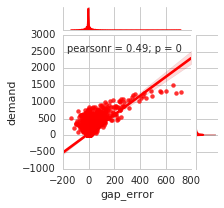

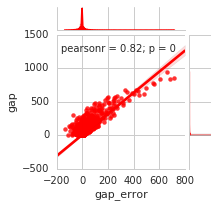

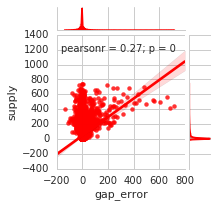

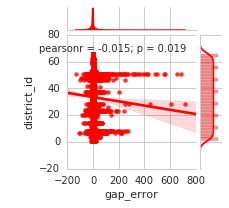

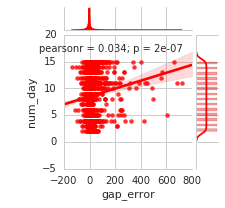

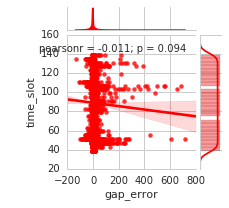

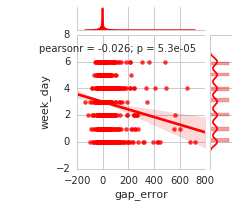

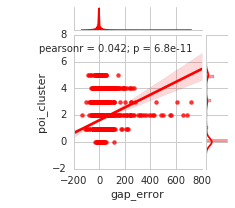

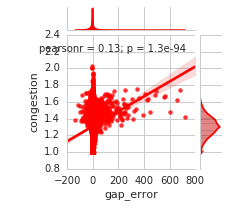


Train Error Joint Plot



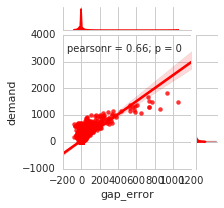

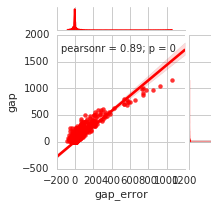

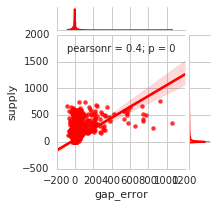

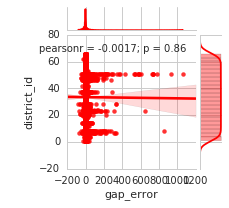

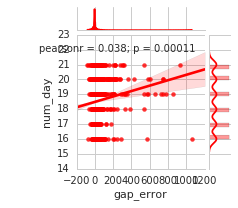

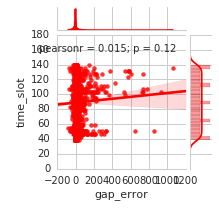

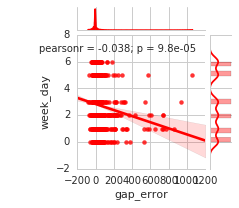

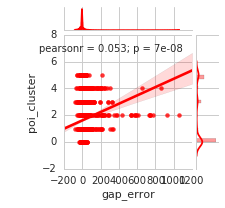

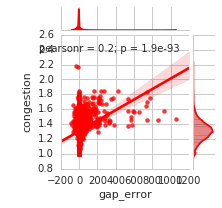

In [60]:
# Print Scores   
g_gs = SVR().fit(X=gX_train, y=gy_train)

gap_estimate(gX_train=gX_train, gX_test=gX_test, g_fitfunc=g_gs)

# LINEAR REGRESSION

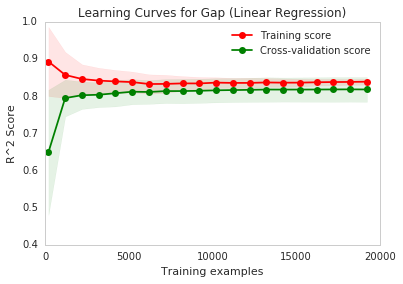


Training Gap Forecaster - Linear Regression

Train Size: 4000.000 Train Score: 0.824 Test Score: 0.851
Train Size: 8000.000 Train Score: 0.817 Test Score: 0.846
Train Size: 12000.000 Train Score: 0.828 Test Score: 0.839
Train Size: 16000.000 Train Score: 0.832 Test Score: 0.842
Train Size: 20000.000 Train Score: 0.835 Test Score: 0.848
Train Size: 24024.000 Train Score: 0.836 Test Score: 0.848


In [57]:
from sklearn.linear_model import LinearRegression

# Linear Regression defaults to R^2 score
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=LinearRegression(), alg_name="Linear Regression")

generate_traintestscores(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                         alg=LinearRegression(), alg_name="Linear Regression")



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	203.53		0.84		0.58
TEST      	490.85		0.85		0.56

Train error correlation matrix:
             district_id       num_day     time_slot      week_day    demand  \
district_id     1.000000  0.000000e+00  0.000000e+00  0.000000e+00 -0.152934   
num_day         0.000000  1.000000e+00  0.000000e+00 -1.240347e-01  0.036766   
time_slot       0.000000  0.000000e+00  1.000000e+00  0.000000e+00  0.021066   
week_day        0.000000 -1.240347e-01  0.000000e+00  1.000000e+00 -0.022982   
demand         -0.152934  3.676635e-02  2.106621e-02 -2.298163e-02  1.000000   
supply         -0.172786  2.757070e-02  4.093527e-02 -1.346714e-02  0.954527   
gap            -0.044760  4.385271e-02 -3.442698e-02 -3.633431e-02  0.707939   
poi_cluster    -0.236061 -1.230315e-18  0.000000e+00 -2.118440e-17  0.283922   
congestion     -0.119551  2.100863e-02  3.417696e-02 -2.870238e-02  0.491235   
gap_error       0.010935  2.421687e-02 -3.348285e-16 -2.075643e-15  0.

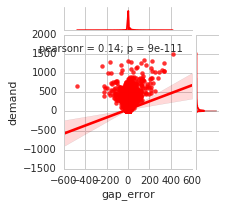

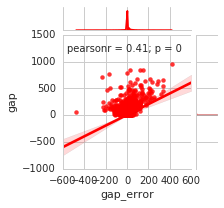

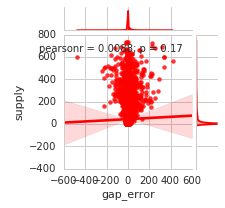

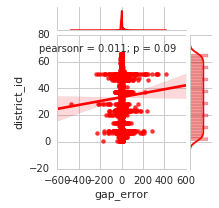

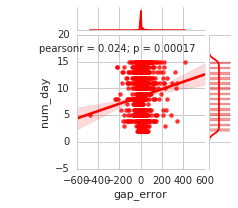

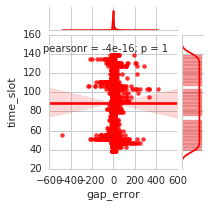

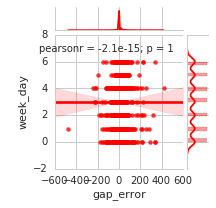

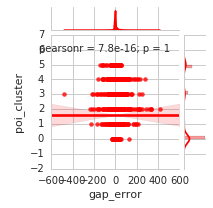

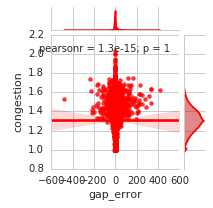


Train Error Joint Plot



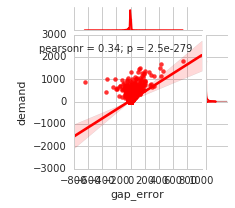

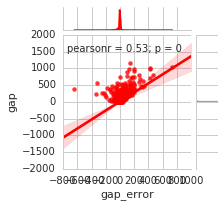

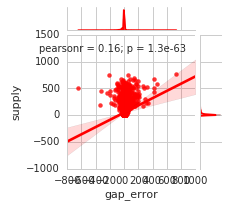

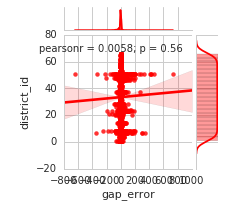

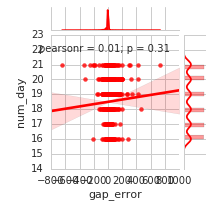

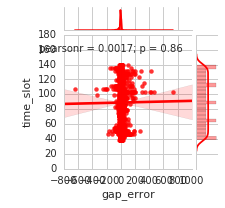

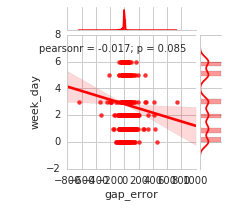

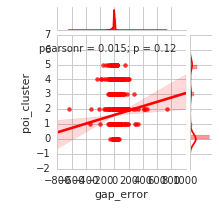

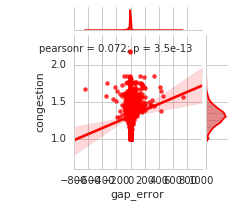

In [58]:
# Print Scores   
g_gs = LinearRegression().fit(X=gX_train, y=gy_train)

gap_estimate(gX_train=gX_train, gX_test=gX_test, g_fitfunc=g_gs)

# BENCHMARK - SIMPLE AVERAGE

In [24]:
# Return simple average of previous 3 time slots
def simple_average(df, t1, t2, t3):
    return df.apply(lambda r: ((r[t1] + r[t2] + r[t3]) / 3.0), axis=1)

# Define list of predictors for demand, supply
r_predictors = ['district_id', 'num_day', 'time_slot', 'demand_t-1', 'demand_t-2', 'demand_t-3'] 
a_predictors = ['district_id', 'num_day', 'time_slot', 'supply_t-1', 'supply_t-2', 'supply_t-3']

# Set arguments for gap forecasting function
kwargs = {"train_set": X_train, "test_set": X_test, 
          "demand_predictors": r_predictors, "supply_predictors": a_predictors,
          "rfit_func": simple_average, "rfit_args": ['demand_t-1','demand_t-2','demand_t-3'],
          "afit_func": simple_average, "afit_args": ['supply_t-1','supply_t-2','supply_t-3']}

gap_forecast(**kwargs)



DEMAND FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	784.82		0.93		3.24
TEST      	1159.29		0.93		1.36


SUPPLY FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	252.86		0.96		2.90
TEST      	273.82		0.97		1.22


GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	508.04		0.59		4.40
TEST      	833.59		0.74		1.89
